In [1]:
# MAIN QUESTION: Is there a difference between observed behaviors among different staff?

import matplotlib.pyplot as plt
import requests
import pandas as pd
import seaborn as sns
import Levenshtein
import os
import glob

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [2]:
# a bit of preprocessing  and the merging the bx data to the appointments  

appointment_list = pd.read_excel('Clean_SBA_AppointmentList.xlsx')
bx_list = pd.read_excel('bx_sheets_merged.xlsx')


bx_cols = ['aggression', 'elope', 'non-compliance', 'protesting', 'sib']

bx_list['Date'] = pd.to_datetime(bx_list['Date'])
appointment_list['Date'] = pd.to_datetime(appointment_list['Date'])

result = pd.merge(appointment_list,bx_list,on=['Client','Date'], how='inner').set_index('Client')

print('Appt list length: ' + str(len(appointment_list)))
print('Bx list length: ' + str(len(bx_list)))
print(bx_list['Date'].dtype,appointment_list['Date'].dtype)
print('Result length: ' + str(result.shape))
print('\nUnique clients: ' + str(len(result.index.unique())))
print('Unique staff: ' + str(len(result['Staff Member'].unique())))

Appt list length: 6139
Bx list length: 693
datetime64[ns] datetime64[ns]
Result length: (608, 9)

Unique clients: 9
Unique staff: 32


In [3]:
a= result.index.unique()

In [4]:
a.names

FrozenList(['Client'])

In [5]:
#for i in result.index.unique():
#    print(i)
#    result.index['Staff Member'] = appointment_list['Staff Member'].str.replace(i,'staff_' + str(staff_number), regex=True)
#    staff_number += 1

In [6]:
result.sample(5)

,Date,Day,Staff Member,Duration,aggression,elope,non-compliance,protesting,sib
Client,,,,,,,,,
client_6,2021-01-19,Tue,staff_11,2.25,7.0,3.0,18.0,NaN,NaN
client_7,2021-01-19,Tue,staff_39,1.00,0.0,0.0,0.0,NaN,0.0
client_6,2021-05-20,Thu,staff_31,2.00,0.0,6.0,2.0,NaN,NaN
client_9,2021-04-30,Fri,staff_9,3.50,8.0,NaN,7.0,NaN,NaN
client_7,2021-03-17,Wed,staff_4,1.25,0.0,0.0,3.0,NaN,3.0


In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, client_1 to client_4
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            608 non-null    datetime64[ns]
 1   Day             608 non-null    object        
 2   Staff Member    608 non-null    object        
 3   Duration        608 non-null    float64       
 4   aggression      608 non-null    float64       
 5   elope           568 non-null    float64       
 6   non-compliance  520 non-null    float64       
 7   protesting      144 non-null    float64       
 8   sib             282 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 63.7+ KB


In [8]:
grid = bx_cols#['aggression','elope','non-compliance']

(array([1., 0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

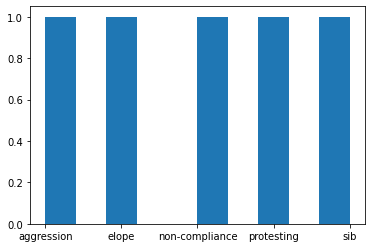

In [9]:
plt.hist(bx_cols, data=result) 

In [10]:
# Make column with day of week 0-6 sun-sat
result['Day'] = result['Date'].dt.dayofweek
result.head()
result['Day'].value_counts()

1    176
2    125
0    103
3    103
4    101
Name: Day, dtype: int64

In [11]:
def client_appts(df, client):
    group = df.groupby(df.index)
    client_df = group.get_group(client)
    length = 0
    return client_df

In [12]:
# Takes a df and a colum and returns mean of the column
def normalize(df,bx_col):

# Which kind of normalizing? Ended up with minmax, but z-score, or?
    bx_col_mean = (df[bx_col] - df[bx_col].min()) / (df[bx_col].max() - df[bx_col].min())

    bx_col_mean = bx_col_mean.mean()
    
    return bx_col_mean

In [13]:
# Takes client_df and staff member choice and returns a df with all of clients appts with particular staff

def staff_for_client(client_df, staff):
    
    staff_client_df = client_df[client_df['Staff Member'] == staff ]
    
    return staff_client_df # this is a full df for a single client with all their staff

In [14]:
# Takes a df of a staff working with particular client and returns df with the staff bx observations 
# normalized totals of observations of bx 

def per_staff_bx_norm(staff_client_df):
    
    per_staff_obs = pd.DataFrame(index=[staff_client_df.index[0]])
    
    
    for bx in bx_cols:
        norm_bx = normalize(staff_client_df,bx)
        
        per_staff_obs[bx] = norm_bx
        per_staff_obs['Staff Member'] = staff_client_df['Staff Member'].unique()
        
        
    return per_staff_obs 

In [15]:
# Takes in a appointment list df and returns a df of normlalized bx for each staff

def full_client_obs_df(df):
    
    
    full_client_for_staff = pd.DataFrame()
    
    for clients in df.index.unique():
        
        client_appts_df = client_appts(df,clients)
        
        for staff in client_appts_df['Staff Member'].unique(): 
            staff_client_df = staff_for_client(client_appts_df, staff)
            per_staff_norm_df = per_staff_bx_norm(staff_client_df)
    
            full_client_for_staff = full_client_for_staff.append(per_staff_norm_df)
        
    return full_client_for_staff

In [16]:
final_df = full_client_obs_df(result)

In [17]:
final_df.head()

,aggression,Staff Member,elope,non-compliance,protesting,sib
client_1,0.129032,staff_1,0.239631,0.096774,0.223118,0.156682
client_1,0.163265,staff_3,0.214286,0.168367,0.182540,0.194444
client_1,0.092437,staff_12,0.183824,0.152941,0.252941,0.153979
client_1,NaN,staff_48,NaN,NaN,NaN,NaN
client_5,0.219298,staff_5,0.332707,NaN,0.617148,NaN


In [27]:

final_df[final_df.index == 'client_1']

,aggression,Staff Member,elope,non-compliance,protesting,sib
client_1,0.129032,staff_1,0.239631,0.096774,0.223118,0.156682
client_1,0.163265,staff_3,0.214286,0.168367,0.182540,0.194444
client_1,0.092437,staff_12,0.183824,0.152941,0.252941,0.153979
client_1,NaN,staff_48,NaN,NaN,NaN,NaN


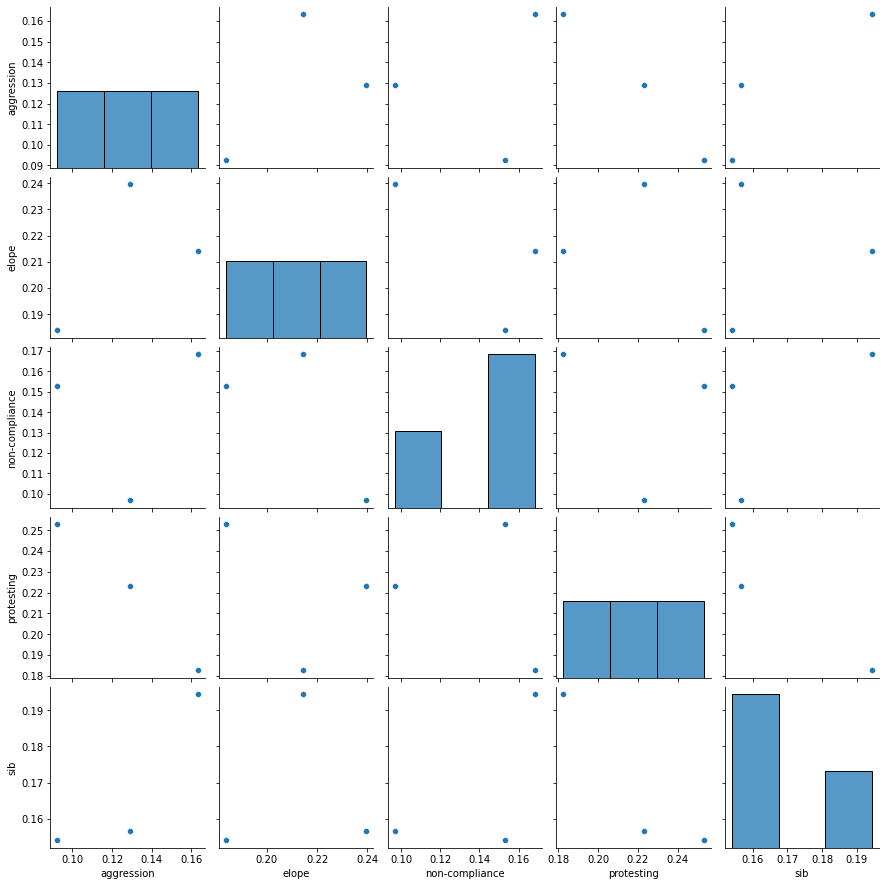

In [26]:
sns.pairplot(final_df[final_df.index == 'client_1'])


In [37]:
final_df.corr()

,aggression,elope,non-compliance,protesting,sib
aggression,1.000000,0.800491,0.530748,0.638361,0.790633
elope,0.800491,1.000000,0.611663,0.705772,0.821394
non-compliance,0.530748,0.611663,1.000000,0.791530,0.815029
protesting,0.638361,0.705772,0.791530,1.000000,0.913927
sib,0.790633,0.821394,0.815029,0.913927,1.000000


<AxesSubplot:>

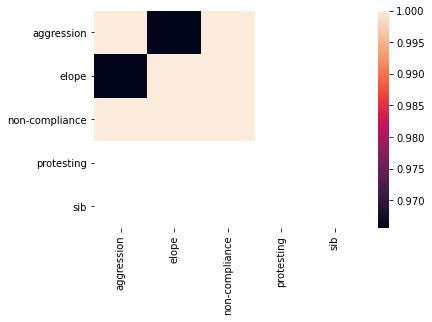

In [33]:
gv_corr = final_df[final_df['Staff Member'] == 'staff_1'].corr()
sns.heatmap(gv_corr)

<AxesSubplot:xlabel='aggression', ylabel='non-compliance'>

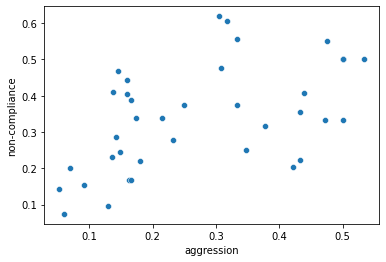

In [36]:
sns.scatterplot(x='aggression', y='non-compliance', data=final_df)

In [23]:
# MAIN QUESTION ANSEWR: Yes, there is a wide range of differences in staff observed bahavior with client
# 
# The result is an easy to work with df that correlations can be found
#
# Possible relationships to explore include differences in observed aggression over all of a particular staff appts,
# as well as including .datofweek, weather at appointment location, time of day and others
#
# actually found difference in correlations with vars, not significantly different observations of bx over staff

result.to_excel('bx_appointments.xlsx')